# Arabic Image Captioning project


###### Arabic image captioning is one of the most challenging tasks in deep learning projects, through the implementation of the projects there were several challnges associated with it such as lack of data and the comlexity of Arabic Language, the project passed through different stages, these stages are clearly discussed though out this notebook.

## Step 1: Import the required libraries

In [144]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import os
from os import listdir
from tqdm import tqdm_notebook, tnrange
import keras
from keras_tqdm import TQDMNotebookCallback
print(keras.__version__)
from bidi import algorithm as bidialg
from  keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.mobilenet_v2 import preprocess_input
from keras.models import Model
import tensorflow as tf
from PIL import Image
#These for NLP:
import nltk
from nltk import word_tokenize
import pyarabic.araby as ar                                     
import string                         
import re                        
from nltk.corpus import stopwords            
from nltk.stem.porter import PorterStemmer   
from nltk.stem import SnowballStemmer
from pyarabic.araby import strip_harakat
from pyarabic.araby import strip_tashkeel
from pyarabic.araby import strip_diacritics
from pyarabic.araby import strip_tatweel, strip_shadda
from pyarabic.araby import normalize_ligature
import pyarabic.number
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from string import punctuation
from tensorflow.keras.layers import concatenate
from keras.models import load_model
from keras.layers import Input, Dense, LSTM, Embedding, Dropout

2.10.0


In [ ]:
from numpy import array
from pickle import load
from keras.preprocessing.text import Tokenizer
from keras.utils import pad_sequences
from keras_preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from keras.utils import plot_model
from keras.models import Model
from keras.layers import add
from keras.callbacks import ModelCheckpoint

## Step 2: define the required directories and files 

In [62]:
directory = 'C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\Dataset\\Flicker8k_Dataset'
arabic_captions_path='C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\Dataset\\Flickr8k_text\\Flickr8k.arabic.full.txt'
images_features_path='C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\workingfile\\features_MobileNet.pkl'
cleaned_captions = 'C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\workingfile\\captions\\clean_text.txt'
filetrain='C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\Dataset\\Flickr8k_text\\Flickr_8k.trainImages.txt'
cleaned_captions_directory='C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\workingfile\\captions\\text_cleaning.txt'

## Check the size of the images

In [38]:

# Initialize the minimum height and width
min_height = float('inf')
min_width = float('inf')
min_img_file = None
# Loop over the images in the directory
for filename in os.listdir(directory):
    # Open the image using PIL
    with Image.open(os.path.join(directory, filename)) as img:
        # Get the image width and height
        width, height = img.size
        # Update the minimum width and height if necessary
        if width < min_width:
            min_width = width
            min_img1_file = os.path.join(directory, filename)
        if height < min_height:
            min_height = height
            min_img_file = os.path.join(directory, filename)
# Open the image with the minimum width and height
min_img = Image.open(min_img_file)
min_img1 = Image.open(min_img1_file)
# Print the minimum width and height
print("Minimum Width:", min_width)
print("Minimum Height:", min_height)
min_img.show() # display the image
min_img1.show()
print(min_img_file)
print(min_img1_file)

Minimum Width: 164
Minimum Height: 127
C:\Users\hp\Desktop\Personal files\HTU\python\project\Dataset\Flicker8k_Dataset\456512643_0aac2fa9ce.jpg
C:\Users\hp\Desktop\Personal files\HTU\python\project\Dataset\Flicker8k_Dataset\3039209547_81cc93fbec.jpg


## Step 3: Load the pre-trained CNN model (MobileNet_V2)

In [3]:
def extract_features(directory):
    #The directory where the images are stored.
    # Load the MobileNetV2 model:
    model = MobileNetV2()

    # Remove the second-to-last layer where the claassification occur:
    model.layers.pop()

    # Create a new model using the modified MobileNetV2 model
    #The Model will take the input of the input and the output of the MobileNetV2():
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    # Print the model summary
    model.summary()
    #The above lines will buils/call the pre-trained model. 
    
    # Create the dictionary variable to save the extracted features based on the ID of the image:
    #Each image     
    features = dict()
    # In the images, each image has its own ID which means that the for loop will loop over a list of images name and save their features:
    for name in listdir(directory):
        #The name in this case is the image ID and the directory is the directory where the image is saved:
        filename = directory + '/' + name
        #The load image step aims to load the images from the specified file and then resize it based on the model requirement.
        #The target size is basically depends on the selected model, in case of MobileNet-V2 the target size is 224*224
        image = load_img(filename, target_size=(224,224))
        #The images then is converted to array instead of tensor:
        image = img_to_array(image)
        #It is important to pass the images size based on the requirements of the model.
        
        image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
        #function is used to normalize the input image data before it is passed through a deep learning model.
        #subtracts the mean image pixel value from each pixel and divides the result by the standard deviation of the image pixel values.
        image = preprocess_input(image)
        #The images then is provided the predict in order to predict the features. 
        feature = model.predict(image, verbose=1)
        #The image id of the extracted features is constructed from the number and the extension, the split will take the image number only.
        image_id = name.split('.')[0]
        features[image_id] = feature
        print('image name is: ' + name)
    return features

## Step 4: Save the extracted features in dynamic directory

###### This step is extreamly important to avoide running the CNN model each time, in this case , the model will be saved on the specidied directory and it will be loaded later on without running the above code.

In [40]:
#Save the extracted features in the required directory:
# Specify the directory where the features will be saved in:
directory = 'C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\workingfile'

# Use os.path.join to combine the directory and the filename
filename = os.path.join(directory, 'features_MobileNet.pkl')

#Specify the name of the data file in which you aim to exract features from:
data= 'C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\Dataset\\Flicker8k_Dataset'      
features=extract_features(data) 

# Save the features to the specified file instead of running the file each single time
pickle.dump(features, open('MobileNet_V2', 'wb'))   

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                                             

KeyboardInterrupt: 

## Step 5: Load the required text document 

In [4]:
def load_document(filename):
    file=open(filename,'r',encoding='utf-8')
    text=file.read()
    file.close()
    return text

In [5]:
def load_captions(caption):
    mapping=dict()
    for line in caption.split('\n'):
        token=line.split('\t') #Split the captions to array of image ID and caoptions
        if len(token)<2: #To skip short captions "في.المنطقة.المشجرة"
           continue
        image_id,image_desc=token[0],token[1:]
        image_id=image_id.split('.')[0] #To remove the extension from the image id
        image_desc='.'.join(image_desc) #To convert it to string
        if image_id not in mapping:
            mapping[image_id]=list() #To add the imge id to the list
         
        mapping[image_id].append(image_desc)  
    return mapping

load_document= load_document(arabic_captions_path)
captions = load_captions(load_document)

In [5]:
load_document

<function __main__.load_document(filename)>

In [44]:
captions

{'1000268201_693b08cb0e': ['طفلة صغيرة تتسلق إلى مسرح خشبي',
  'طفلة صغيرة تتسلق الدرج إلى منزلها',
  'فتاة صغيرة في ثوب وردي تذهب إلى المقصورة الخشبية'],
 '1001773457_577c3a7d70': ['كلب أسود وكلب ثلاثي الألوان يلعبان مع بعضهما البعض على الطريق',
  'كلب أسود وكلب أبيض ببقع بنية يحدقان في بعضهما البعض في الشارع',
  'كلاب على الرصيف تتحرك نحو بعضها البعض'],
 '1002674143_1b742ab4b8': ['فتاة صغيرة مغطاة بالطلاء تجلس أمام قوس قزح',
  'فتاة صغيرة تجلس أمام قوس قزح ملون كبير',
  'فتاة أمام لوحة قوس قزح'],
 '1003163366_44323f5815': ['رجل يجلس على مقعد بينما يجلس كلبه بجانبه',
  'رجل ينام على مقعد في الخارج مع كلب أبيض وأسود يجلس بجانبه',
  'رجل بلا قميص يجلس على مقعد في الحديقة مع كلبه'],
 '1007129816_e794419615': ['رجل يرتدي قبعة برتقالية',
  'رجل يرتدي قبعة برتقالية ونظارات',
  'الرجل ذو الأذن المثقوبة يرتدي نظارات وقبعة برتقالية اللون'],
 '1007320043_627395c3d8': ['طفل يلعب على حبل',
  'فتاة صغيرة تتسلق على الحبل الأحمر',
  'طفل صغير يمسك بالحبال الحمراء في الملعب'],
 '1009434119_febe49276a

## Step 6: Visualize the images with their captions 

###### This is not as a part of the model, but it provides deep understanding of whole image and the dataset at all.

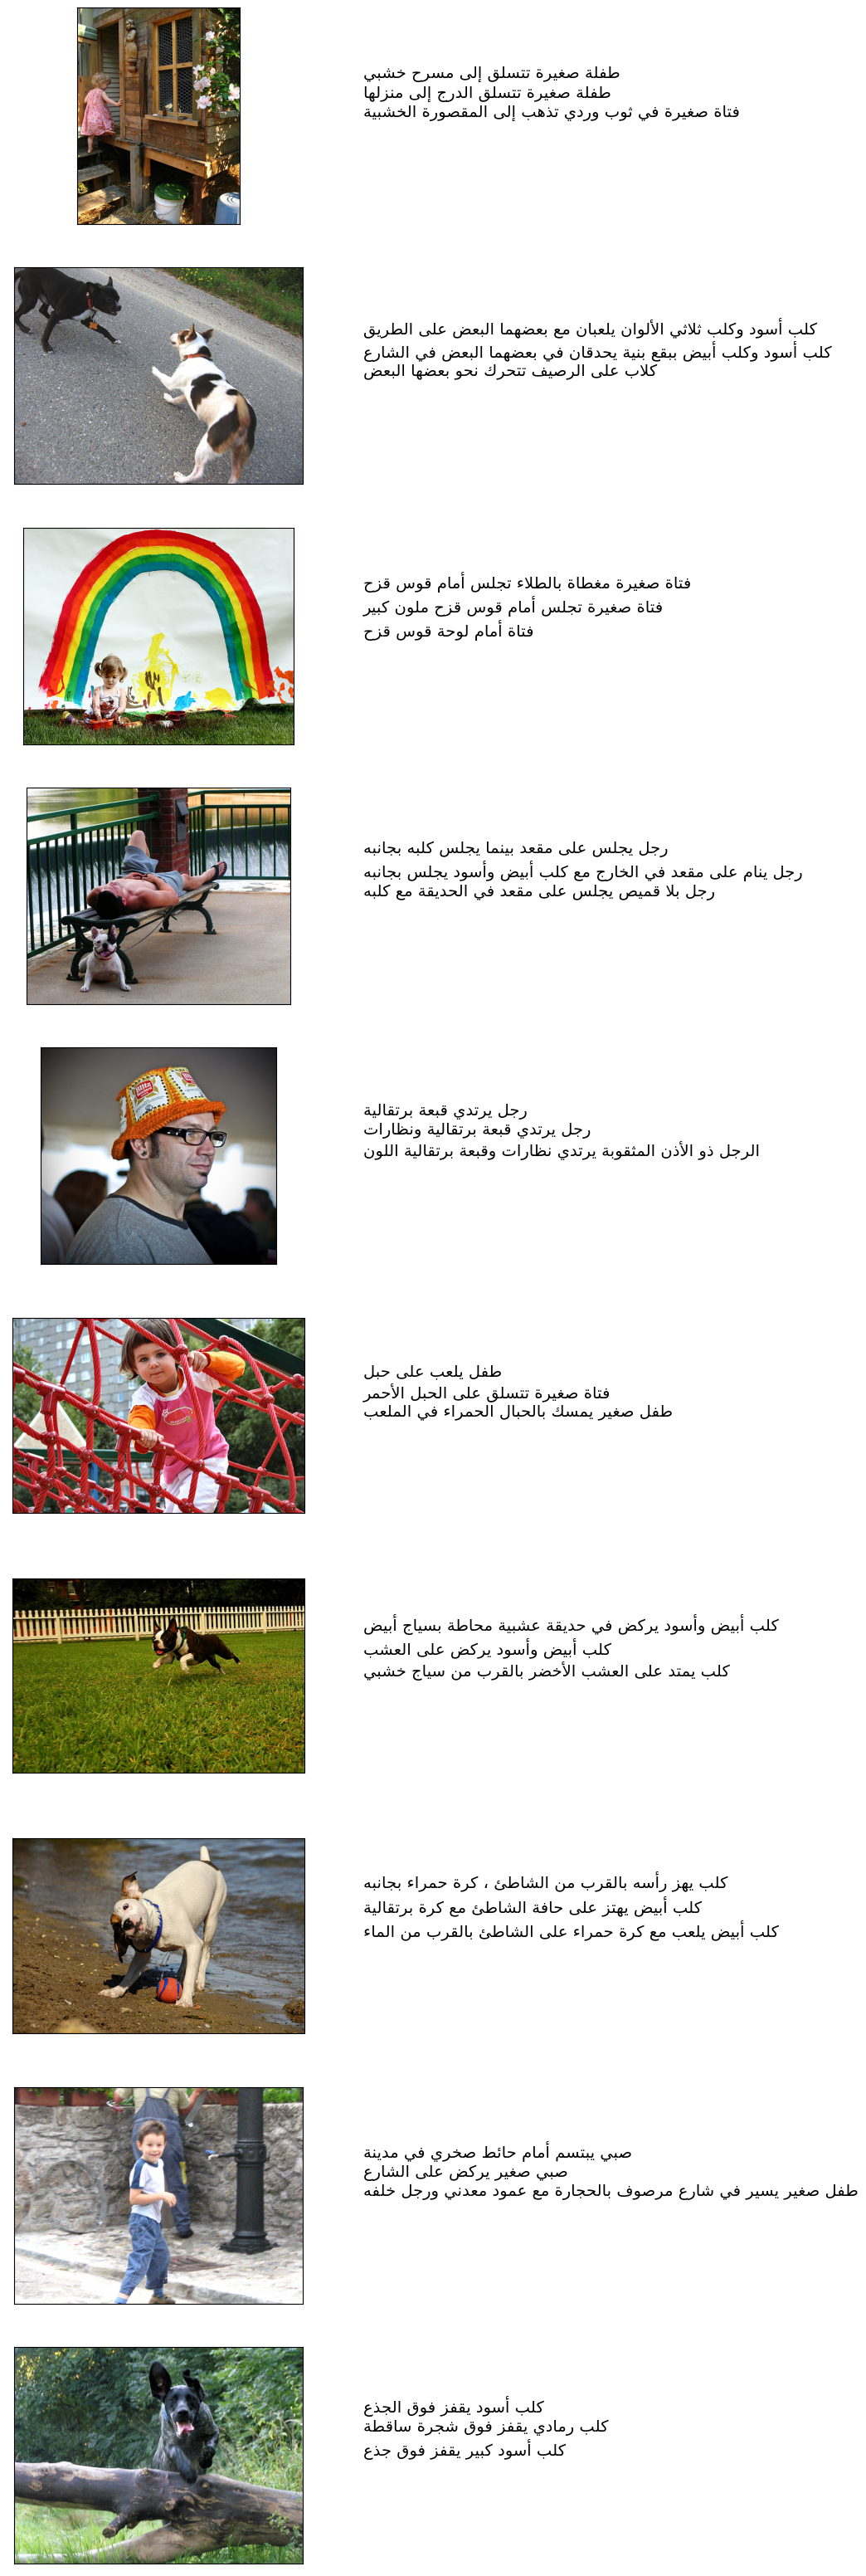

In [8]:
def visualize_images_with_captions(cpts):
    """plot images with their captions"""
    n_pics = len(cpts)
    i = 0
    fig = plt.figure(figsize=(10,n_pics*4))
    #for i,line in enumerate(lines[:n_pics]):
    for img,cpt in captions.items():
         img_file = img + '.jpg'
         img = load_img(directory + '\\' + img_file)
         cpt_ = '\n'.join(cpt)
         caption = arabic_reshaper.reshape(cpt_)
         caption = bidialg.get_display(caption)
         ax = fig.add_subplot(n_pics,2,2*i+1,xticks=[],yticks=[])
         ax.imshow(img)
         ax = fig.add_subplot(n_pics,2,2*i+2)
         plt.axis('off')
         ax.plot()
         ax.set_xlim(0,1)
         ax.set_ylim(0,1)
         ax.text(0,0.5,caption,fontdict={'color':  'black','weight': 'normal','size': 14}) 
         i += 1
         if i >= n_pics:
              break
subset = {k:captions[k] for k in list(captions.keys())[:10]}
visualize_images_with_captions(subset)

## Step 7: Create a data frame of the captions

In [12]:
#Create data frame that shows all captions:
file = open('C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\Dataset\\Flickr8k_text\\Flickr8k.arabic.full.txt','r',encoding='utf-8')
text = file.read()
file.close()

datatxt = []
for line in text.split('\n'):
   col = line.split('\t')
   if len(col) == 1:
       continue
   w = col[0].split("#")
   datatxt.append(w + [col[1].lower()])

data = pd.DataFrame(datatxt,columns=["file","index","caption"])
data = data.reindex(columns =['index','file','caption'])
data = data[data.file != '2258277193_586949ec62.jpg']
uni_filenames = np.unique(data.file.values)

data.head()

index                       file  \
0     0  1000268201_693b08cb0e.jpg   
1     1  1000268201_693b08cb0e.jpg   
2     2  1000268201_693b08cb0e.jpg   
3     0  1001773457_577c3a7d70.jpg   
4     1  1001773457_577c3a7d70.jpg   

                                             caption  
0                     طفلة صغيرة تتسلق إلى مسرح خشبي  
1                  طفلة صغيرة تتسلق الدرج إلى منزلها  
2   فتاة صغيرة في ثوب وردي تذهب إلى المقصورة الخشبية  
3  كلب أسود وكلب ثلاثي الألوان يلعبان مع بعضهما ا...  
4  كلب أسود وكلب أبيض ببقع بنية يحدقان في بعضهما ...

## Step 8: Data visualization for further information

###### Calculating the maximum length of the captions

In [23]:
def calc_max_length(length):
    maximum_length=max(len(t) for t in length)
    return maximum_length
# To calculate the total amount of characters 

calc_max_length(captions)

21

In [26]:
#%%: check the number of charachters in the dataframe:
data['caption'].apply(lambda x: len(x.split())).sum() 


179531

In [28]:
data['caption'].apply(lambda x: len(x)).sum() 
#There are 934144 charachters in the dataframe(text dataframe)

934144

###### Finding out the vocabulary size , it is important because the RNN will only take unique words.
As seen in the dataframe , some words repeated several times such as 'في', and in order to avoide any errors in the model, it was only trained on the unique words. 

In [19]:
from collections import Counter 

def df_word(df_txt):
    vocabulary = []

    for i in range(len(df_txt)):
        temp=df_txt.iloc[i,2]
        vocabulary.extend(temp.split())

    print('Vocabulary Size: %d' % len(set(vocabulary)))
    ct = Counter(vocabulary)
    dfword = pd.DataFrame({"word":list(ct.keys()),"count":list(ct.values())})
    dfword = dfword.sort_values("count",ascending=False)
    dfword = dfword.reset_index()[["word","count"]]
    return(dfword)

dfword = df_word(data)
dfword.head()

Vocabulary Size: 11384


word  count
0   في  11095
1  على   7572
2   من   4723
3  كلب   4024
4  رجل   4024

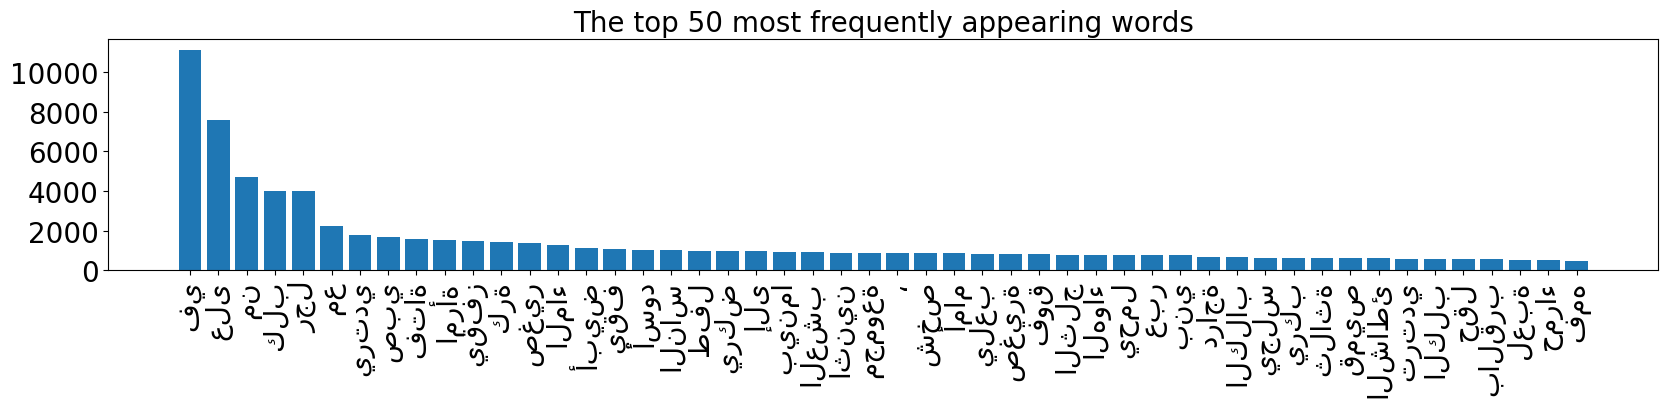

In [14]:
topn = 50

def plthist(dfsub, title="The top 50 most frequently appearing words"):
    plt.figure(figsize=(20,3))
    plt.bar(dfsub.index,dfsub["count"])
    plt.yticks(fontsize=20)
    plt.xticks(dfsub.index,dfsub["word"],rotation=90,fontsize=20)
    plt.title(title,fontsize=20)
    plt.show()

plthist(dfword.iloc[:topn,:],
        title="The top 50 most frequently appearing words")

## Step 9: Text cleaning and preparation

### 9.1 Download define the punctuations_list

###### To ensure that the text won't include any special character, both English and Arabic list were used.   

In [6]:
nltk.download('punkt') # Download the english punctuation
arabic_punctuations = '''`÷×؛<>_()*&^%][ـ،/:"؟.,'{}~¦+|!”…“–ـ'''
english_punctuations = string.punctuation     # Get all the special characters.   
punctuations_list = arabic_punctuations + english_punctuations  


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


### 9.2 Text pre-processing

###### This step means to remove any undesired elements from the text in order to ensure that the model is well cleaned and trained correctly, the cleaning includes the following:
1. Remove the punctuations.
2. Remove any single character.
3. Remove the numeric values by replacing them with Arabic number words.
4. Remove the defining words which is called (ال التعريف).
5. Remove the Harakat from the text.

In [114]:
def remove_punctuations(data):
    return ''.join([c for c in data if c not in punctuations_list])
#def remove_punctuation(text):
    #text_no_punctuation = re.sub(r'[^\w\s]', '', text)
    #return text_no_punctuation

def remove_single_character(text):
    text_len_more_than1 = ""
    for word in text.split():
        if len(word) > 1:
            text_len_more_than1 += " " + word
    return(text_len_more_than1)

def remove_numeric(text):
    # Use regular expression to extract all Arabic numerals from the text
    numerals = re.findall(r'\d+', text)
    # Convert each numeral to its corresponding word form
    an = pyarabic.number.ArNumbers()
    text_no_numeric = text
    for numeral in numerals:
        word_form = an.int2str((numeral))
        text_no_numeric = text_no_numeric.replace(numeral, word_form)
    return text_no_numeric
 
def remove_defining_words(text):
    text_with_no_defining_chr=re.sub(r'\bال(\w\w+)', r'\1', text)
    return text_with_no_defining_chr


def remove_harakat(text):
    text_no_harakat=strip_tashkeel(text)
    text_no_diacritics=strip_diacritics(text_no_harakat)
    text_no_tatweel=strip_tatweel(text_no_diacritics)
    text_wihout_english=re.sub(r'[a-zA-Z]+', '',text_no_tatweel)
    return (text_wihout_english)

def clean_text(data):
    text = remove_punctuations(data)
    text = remove_numeric(text)
    text = remove_single_character(text)
    text=remove_defining_words(text)
    text=remove_harakat(text)
    return(text)


for i, caption in enumerate(data.caption.values):
   cleaned_text = clean_text(caption)
   data["caption"].iloc[i] = cleaned_text

###### An exmample of how the results are look like is provided below:

In [115]:
text='ذهبتُ إلى الحديقة مع صديقتي، وهناك شاهدنا 3 أنواعً من الحيواناتِ البرية'
clean_text(text)

' ذهبت إلى حديقة مع صديقتي وهناك شاهدنا ثلاث أنواع من حيوانات برية'

In [111]:
data

index                       file  \
0         0  1000268201_693b08cb0e.jpg   
1         1  1000268201_693b08cb0e.jpg   
2         2  1000268201_693b08cb0e.jpg   
3         0  1001773457_577c3a7d70.jpg   
4         1  1001773457_577c3a7d70.jpg   
...     ...                        ...   
24268     1   997338199_7343367d7f.jpg   
24269     2   997338199_7343367d7f.jpg   
24270     0   997722733_0cb5439472.jpg   
24271     1   997722733_0cb5439472.jpg   
24272     2   997722733_0cb5439472.jpg   

                                                 caption  
0                         طفلة صغيرة تتسلق إلى مسرح خشبي  
1                        طفلة صغيرة تتسلق درج إلى منزلها  
2           فتاة صغيرة في ثوب وردي تذهب إلى مقصورة خشبية  
3       كلب أسود وكلب ثلاثي ألوان يلعبان مع بعضهما بع...  
4       كلب أسود وكلب أبيض ببقع بنية يحدقان في بعضهما...  
...                                                  ...  
24268                امرأة تقف بالقرب من جدار مزخرف تكتب  
24269                        جدران مغطاة بالذهب والأنماط  
24270             رجل يرتدي قميصا ورديا يتسلق وجها صخريا  
24271                             رجل يتسلق صخور في هواء  
24272                            متسلق صخرة في قميص أحمر  

[24273 rows x 3 columns]

In [47]:
def clean_descriptions(descriptions):
    table=str.maketrans('','',string.punctuation)
    for key,desc_list in descriptions.items():
        for i in range (len(desc_list)):
            desc=desc_list[i]
            desc=desc.split()
            desc=[w.translate(table) for w in desc]
            desc=[word for word in desc if len(word)>1]
            desc=[word for word in desc if word.isalpha()]
            desc_list[i]=' '.join(desc)
    return descriptions


In [49]:
clean_descriptions(captions)

{'1000268201_693b08cb0e': ['طفلة صغيرة تتسلق إلى مسرح خشبي',
  'طفلة صغيرة تتسلق الدرج إلى منزلها',
  'فتاة صغيرة في ثوب وردي تذهب إلى المقصورة الخشبية'],
 '1001773457_577c3a7d70': ['كلب أسود وكلب ثلاثي الألوان يلعبان مع بعضهما البعض على الطريق',
  'كلب أسود وكلب أبيض ببقع بنية يحدقان في بعضهما البعض في الشارع',
  'كلاب على الرصيف تتحرك نحو بعضها البعض'],
 '1002674143_1b742ab4b8': ['فتاة صغيرة مغطاة بالطلاء تجلس أمام قوس قزح',
  'فتاة صغيرة تجلس أمام قوس قزح ملون كبير',
  'فتاة أمام لوحة قوس قزح'],
 '1003163366_44323f5815': ['رجل يجلس على مقعد بينما يجلس كلبه بجانبه',
  'رجل ينام على مقعد في الخارج مع كلب أبيض وأسود يجلس بجانبه',
  'رجل بلا قميص يجلس على مقعد في الحديقة مع كلبه'],
 '1007129816_e794419615': ['رجل يرتدي قبعة برتقالية',
  'رجل يرتدي قبعة برتقالية ونظارات',
  'الرجل ذو الأذن المثقوبة يرتدي نظارات وقبعة برتقالية اللون'],
 '1007320043_627395c3d8': ['طفل يلعب على حبل',
  'فتاة صغيرة تتسلق على الحبل الأحمر',
  'طفل صغير يمسك بالحبال الحمراء في الملعب'],
 '1009434119_febe49276a

In [7]:
# convert loaded descriptions to unique vocabs:
def to_vocabulary(descriptions):
    all_desc=set()
    for key in descriptions.keys():
         [all_desc.update(d.split())for d in descriptions[key]]
    return all_desc

In [ ]:
#load clean description into memory:

In [66]:
def load_clean_descriptions(filename,dataset):
    doc=load_document(filename)
    descriptions=dict()
    for line in doc.split('\n'):
        tokens=line.split()
        image_id,image_desc=tokens[0],tokens[1:]
    #skip images not in set:
        if image_id in dataset:
            #create list:
            if image_id not in descriptions:
                descriptions[image_id]=list()
            desc='startseq '+ ' '.join(image_desc)+' endseq'
            descriptions[image_id].append(desc)
    return descriptions


In [101]:
a=preprocess_captions(captions)

In [103]:
captions

{'1000268201_693b08cb0e': ['طفلة صغيرة تتسلق إلى مسرح خشبي',
  'طفلة صغيرة تتسلق درج إلى منزلها',
  'فتاة صغيرة في ثوب وردي تذهب إلى مقصورة خشبية'],
 '1001773457_577c3a7d70': ['كلب أسود وكلب ثلاثي ألوان يلعبان مع بعضهما بعض على طريق',
  'كلب أسود وكلب أبيض ببقع بنية يحدقان في بعضهما بعض في شارع',
  'كلاب على رصيف تتحرك نحو بعضها بعض'],
 '1002674143_1b742ab4b8': ['فتاة صغيرة مغطاة بالطلاء تجلس أمام قوس قزح',
  'فتاة صغيرة تجلس أمام قوس قزح ملون كبير',
  'فتاة أمام لوحة قوس قزح'],
 '1003163366_44323f5815': ['رجل يجلس على مقعد بينما يجلس كلبه بجانبه',
  'رجل ينام على مقعد في خارج مع كلب أبيض وأسود يجلس بجانبه',
  'رجل بلا قميص يجلس على مقعد في حديقة مع كلبه'],
 '1007129816_e794419615': ['رجل يرتدي قبعة برتقالية',
  'رجل يرتدي قبعة برتقالية ونظارات',
  'رجل ذو أذن مثقوبة يرتدي نظارات وقبعة برتقالية لون'],
 '1007320043_627395c3d8': ['طفل يلعب على حبل',
  'فتاة صغيرة تتسلق على حبل أحمر',
  'طفل صغير يمسك بالحبال حمراء في ملعب'],
 '1009434119_febe49276a': ['كلب أبيض وأسود يركض في حديقة عشبية 

In [40]:
###### An example of how the captions will looks like:
text='ذَهبتُ إلى الحديقةِ وشاهدت 4 فتيات يطعمنَ البط، ويساعدن المحتاجين!'
clean_text(text)

' ذهبت إلى حديقة وشاهدت أربع فتيات يطعمن بط ويساعدن محتاجين'

In [41]:
data

index                       file  \
0         0  1000268201_693b08cb0e.jpg   
1         1  1000268201_693b08cb0e.jpg   
2         2  1000268201_693b08cb0e.jpg   
3         0  1001773457_577c3a7d70.jpg   
4         1  1001773457_577c3a7d70.jpg   
...     ...                        ...   
24268     1   997338199_7343367d7f.jpg   
24269     2   997338199_7343367d7f.jpg   
24270     0   997722733_0cb5439472.jpg   
24271     1   997722733_0cb5439472.jpg   
24272     2   997722733_0cb5439472.jpg   

                                                 caption  
0                         طفلة صغيرة تتسلق إلى مسرح خشبي  
1                        طفلة صغيرة تتسلق درج إلى منزلها  
2           فتاة صغيرة في ثوب وردي تذهب إلى مقصورة خشبية  
3       كلب أسود وكلب ثلاثي ألوان يلعبان مع بعضهما بع...  
4       كلب أسود وكلب أبيض ببقع بنية يحدقان في بعضهما...  
...                                                  ...  
24268                امرأة تقف بالقرب من جدار مزخرف تكتب  
24269                        جدران مغطاة بالذهب والأنماط  
24270             رجل يرتدي قميصا ورديا يتسلق وجها صخريا  
24271                             رجل يتسلق صخور في هواء  
24272                            متسلق صخرة في قميص أحمر  

[24273 rows x 3 columns]

###### Test the vocabulary size after cleaning

In [42]:
clean_vocabulary = []
for txt in data.caption.values:
   clean_vocabulary.extend(txt.split())
print('Clean Vocabulary Size: %d' % len(set(clean_vocabulary)))   #In order to only save the unique vocabs the set type was used.

Clean Vocabulary Size: 9485


In [49]:
clean_vocabulary

['طفلة',
 'صغيرة',
 'تتسلق',
 'إلى',
 'مسرح',
 'خشبي',
 'طفلة',
 'صغيرة',
 'تتسلق',
 'درج',
 'إلى',
 'منزلها',
 'فتاة',
 'صغيرة',
 'في',
 'ثوب',
 'وردي',
 'تذهب',
 'إلى',
 'مقصورة',
 'خشبية',
 'كلب',
 'أسود',
 'وكلب',
 'ثلاثي',
 'ألوان',
 'يلعبان',
 'مع',
 'بعضهما',
 'بعض',
 'على',
 'طريق',
 'كلب',
 'أسود',
 'وكلب',
 'أبيض',
 'ببقع',
 'بنية',
 'يحدقان',
 'في',
 'بعضهما',
 'بعض',
 'في',
 'شارع',
 'كلاب',
 'على',
 'رصيف',
 'تتحرك',
 'نحو',
 'بعضها',
 'بعض',
 'فتاة',
 'صغيرة',
 'مغطاة',
 'بالطلاء',
 'تجلس',
 'أمام',
 'قوس',
 'قزح',
 'فتاة',
 'صغيرة',
 'تجلس',
 'أمام',
 'قوس',
 'قزح',
 'ملون',
 'كبير',
 'فتاة',
 'أمام',
 'لوحة',
 'قوس',
 'قزح',
 'رجل',
 'يجلس',
 'على',
 'مقعد',
 'بينما',
 'يجلس',
 'كلبه',
 'بجانبه',
 'رجل',
 'ينام',
 'على',
 'مقعد',
 'في',
 'خارج',
 'مع',
 'كلب',
 'أبيض',
 'وأسود',
 'يجلس',
 'بجانبه',
 'رجل',
 'بلا',
 'قميص',
 'يجلس',
 'على',
 'مقعد',
 'في',
 'حديقة',
 'مع',
 'كلبه',
 'رجل',
 'يرتدي',
 'قبعة',
 'برتقالية',
 'رجل',
 'يرتدي',
 'قبعة',
 'برتقالية',
 'ونظارات'

### 9.3 Save the cleaned captions:

###### Again, it is important to make the project dynamic and save the time while implementing and running stage, accordingly the captions were saved on external file to be called later on.

In [ ]:
# Update the function to take the cleaned captions and the desired file name and location
def save_descriptions(descriptions, filename):
    with open(filename, 'w',encoding='utf-8') as file:
        for desc in descriptions:
            file.write(desc + '\n')

# Define the desired file name and location on the desktop
#cleaned_captions = 'C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\workingfile\\captions\\clean_text.txt'

# Collect the cleaned captions in a list
cleaned_captions = []
for i, caption in enumerate(data.caption.values):
   cleaned_text = clean_text(caption)
   cleaned_captions.append(cleaned_text)
   data["caption"].iloc[i] = cleaned_text
# Save the cleaned captions to the desired file
save_descriptions(cleaned_captions, cleaned_captions) 

In [58]:
def save_descriptions(descriptions, filename):
    lines=list()
    for key , desc_list in descriptions.items():
        for desc in desc_list:
            lines.append(key+ ' '+desc)
    data='\n'.join(lines)
    with open(filename,'w', encoding='utf-8') as file:
        file.write(data)


In [61]:
save_descriptions(captions, cleaned_captions_directory)

## Step 10: Load the required files to memory

The last step is to build the LSTM model, to build the LSTM model, there are set of steps that should be done, these are listed below:

###### 1. Load document into memory:

In [12]:
def load_document(filename):
    with open(filename,'r',encoding='utf-8') as file:
        text=file.read()
    return text


###### 2. Load the pre-trained list of photo identifier:

In [13]:
def load_set(filename):
    doc=load_document(filename)
    dataset=list()
    for line in doc.split('\n'):
        if len(line)<1:
            continue
        identifier=line.split('.')[0]
        dataset.append(identifier)
    return set(dataset)

###### 3. Add the prefix and suffix to each caption:

This step is extremely important, because in this way the model will know when to start and when to stop the prediction process.

In [83]:
def load_clean_descriptions(captions):
    caps = []
    for txt in captions:
        txt = 'startseq ' + txt + ' endseq'
        caps.append(txt)
    return(caps)
#The aim of this function is to add the starting and ending point to the captions

data['caption'] = load_clean_descriptions(data['caption'])
data

index                       file  \
0         0  1000268201_693b08cb0e.jpg   
1         1  1000268201_693b08cb0e.jpg   
2         2  1000268201_693b08cb0e.jpg   
3         0  1001773457_577c3a7d70.jpg   
4         1  1001773457_577c3a7d70.jpg   
...     ...                        ...   
24268     1   997338199_7343367d7f.jpg   
24269     2   997338199_7343367d7f.jpg   
24270     0   997722733_0cb5439472.jpg   
24271     1   997722733_0cb5439472.jpg   
24272     2   997722733_0cb5439472.jpg   

                                                 caption  
0        startseq  طفلة صغيرة تتسلق إلى مسرح خشبي endseq  
1       startseq  طفلة صغيرة تتسلق درج إلى منزلها endseq  
2      startseq  فتاة صغيرة في ثوب وردي تذهب إلى مقصو...  
3      startseq  كلب أسود وكلب ثلاثي ألوان يلعبان مع ...  
4      startseq  كلب أسود وكلب أبيض ببقع بنية يحدقان ...  
...                                                  ...  
24268  startseq  امرأة تقف بالقرب من جدار مزخرف تكتب ...  
24269       startseq  جدران مغطاة بالذهب والأنماط endseq  
24270  startseq  رجل يرتدي قميصا ورديا يتسلق وجها صخر...  
24271            startseq  رجل يتسلق صخور في هواء endseq  
24272           startseq  متسلق صخرة في قميص أحمر endseq  

[24273 rows x 3 columns]

###### 4. Load the file that contains the image features:

In [60]:
def load_photo_features(filename):
    features = pickle.load(open(images_features_path, 'rb'))
    return features

In [ ]:
#new:
def load_photo_features(filename,dataset):
    all_features=pickle.load(open(filename,'rb'))
    features={k: all_features[k] for k in dataset}
    return features

In [61]:
load_photo_features(images_features_path)

{'1000268201_693b08cb0e': array([[1.1539997 , 0.        , 0.91584325, ..., 0.2988178 , 0.08030485,
         0.64647186]], dtype=float32),
 '1001773457_577c3a7d70': array([[0.18050951, 0.5350406 , 0.06814992, ..., 0.44959632, 0.8188827 ,
         0.        ]], dtype=float32),
 '1002674143_1b742ab4b8': array([[1.1606246 , 0.26089087, 0.        , ..., 0.7698089 , 0.04454983,
         0.        ]], dtype=float32),
 '1003163366_44323f5815': array([[0.47087502, 0.43014973, 1.1246681 , ..., 1.49156   , 0.        ,
         0.1240319 ]], dtype=float32),
 '1007129816_e794419615': array([[0.6154648 , 0.397833  , 0.        , ..., 0.        , 3.4576445 ,
         0.02781598]], dtype=float32),
 '1007320043_627395c3d8': array([[0.        , 0.02733046, 0.        , ..., 0.        , 0.        ,
         0.14494249]], dtype=float32),
 '1009434119_febe49276a': array([[0.42177597, 0.        , 0.7805364 , ..., 0.53826416, 0.29384542,
         0.        ]], dtype=float32),
 '1012212859_01547e3f17': array([[

###### Determain the size of the training set

In [14]:
train=load_set(filetrain)
print('Dataset %d' % len(train))

Dataset 6000


In [73]:
train

{'2251992614_0c601fae2c',
 '861608773_bdafd5c996',
 '1469358746_2a879abaf3',
 '3000722396_1ae2e976c2',
 '3081363964_d404eccae8',
 '2568656919_6e49d2a82b',
 '1115565519_d976d4b1f1',
 '2131762850_5293a288d9',
 '3657209354_cde9bbd2c5',
 '2265100168_175f8218af',
 '2218334049_e649dbdb1a',
 '2855727603_e917ded363',
 '278559394_b23af734b9',
 '1350948838_fdebe4ff65',
 '495340319_705f2e63d6',
 '3368671163_0171259581',
 '1514957266_a19827c538',
 '3376942201_2c45d99237',
 '2560278143_aa5110aa37',
 '3544669026_1b5c0e6316',
 '3426789838_8771f0ed56',
 '539667015_fd0a3bea07',
 '3368569524_a9df2fc312',
 '3060519665_4d6b9a51b2',
 '1937262236_cbf5bfa101',
 '1024138940_f1fefbdce1',
 '2346629210_8d6668d22d',
 '436608339_f1d1298770',
 '3583065748_7d149a865c',
 '1026685415_0431cbf574',
 '146577646_9e64b8c2dc',
 '2876994989_a4ebbd8491',
 '2567812221_30fb64f5e9',
 '2887614578_ed7ba21775',
 '3113769557_9edbb8275c',
 '3663307538_468739e4c3',
 '3178005751_fca19815ac',
 '717673249_ac998cfbe6',
 '2545363449_198590

In [26]:
train_features=load_photo_features(images_features_path,train)
print('Dataset %d' % len(train_features))

Dataset 6000


In [72]:
train_features

{'2251992614_0c601fae2c': array([[0.19079687, 0.27762493, 0.40917608, ..., 0.01036158, 0.19766477,
         0.12431908]], dtype=float32),
 '861608773_bdafd5c996': array([[0.00549648, 0.        , 0.0812369 , ..., 0.        , 0.2452818 ,
         0.01560691]], dtype=float32),
 '1469358746_2a879abaf3': array([[0.07985472, 0.03254031, 1.3123798 , ..., 0.08661558, 0.52121234,
         0.37317327]], dtype=float32),
 '3000722396_1ae2e976c2': array([[1.2910931 , 0.7086609 , 0.58955735, ..., 0.8383263 , 0.02857969,
         0.        ]], dtype=float32),
 '3081363964_d404eccae8': array([[0.48338544, 0.69214475, 0.        , ..., 0.22435778, 0.9155459 ,
         0.        ]], dtype=float32),
 '2568656919_6e49d2a82b': array([[0.00305775, 1.5993104 , 1.6419626 , ..., 0.        , 0.        ,
         0.99768823]], dtype=float32),
 '1115565519_d976d4b1f1': array([[0.4120841 , 0.30452007, 1.5613672 , ..., 1.8524166 , 0.4086622 ,
         1.4266018 ]], dtype=float32),
 '2131762850_5293a288d9': array([[0

In [70]:
train_descriptions=load_clean_descriptions(cleaned_captions_directory,train)
print('Dataset %d' % len(train_descriptions))

Dataset 6000


In [69]:
train_descriptions

{'1000268201_693b08cb0e': ['startseq طفلة صغيرة تتسلق إلى مسرح خشبي endseq',
  'startseq طفلة صغيرة تتسلق الدرج إلى منزلها endseq',
  'startseq فتاة صغيرة في ثوب وردي تذهب إلى المقصورة الخشبية endseq'],
 '1001773457_577c3a7d70': ['startseq كلب أسود وكلب ثلاثي الألوان يلعبان مع بعضهما البعض على الطريق endseq',
  'startseq كلب أسود وكلب أبيض ببقع بنية يحدقان في بعضهما البعض في الشارع endseq',
  'startseq كلاب على الرصيف تتحرك نحو بعضها البعض endseq'],
 '1002674143_1b742ab4b8': ['startseq فتاة صغيرة مغطاة بالطلاء تجلس أمام قوس قزح endseq',
  'startseq فتاة صغيرة تجلس أمام قوس قزح ملون كبير endseq',
  'startseq فتاة أمام لوحة قوس قزح endseq'],
 '1003163366_44323f5815': ['startseq رجل يجلس على مقعد بينما يجلس كلبه بجانبه endseq',
  'startseq رجل ينام على مقعد في الخارج مع كلب أبيض وأسود يجلس بجانبه endseq',
  'startseq رجل بلا قميص يجلس على مقعد في الحديقة مع كلبه endseq'],
 '1007129816_e794419615': ['startseq رجل يرتدي قبعة برتقالية endseq',
  'startseq رجل يرتدي قبعة برتقالية ونظارات ends

## Step 11: Build the LSTM model

The proposed model architecture shown in the Figure for Arabic image captioning consists of the encoder (on the left) and the decoder (right side). 
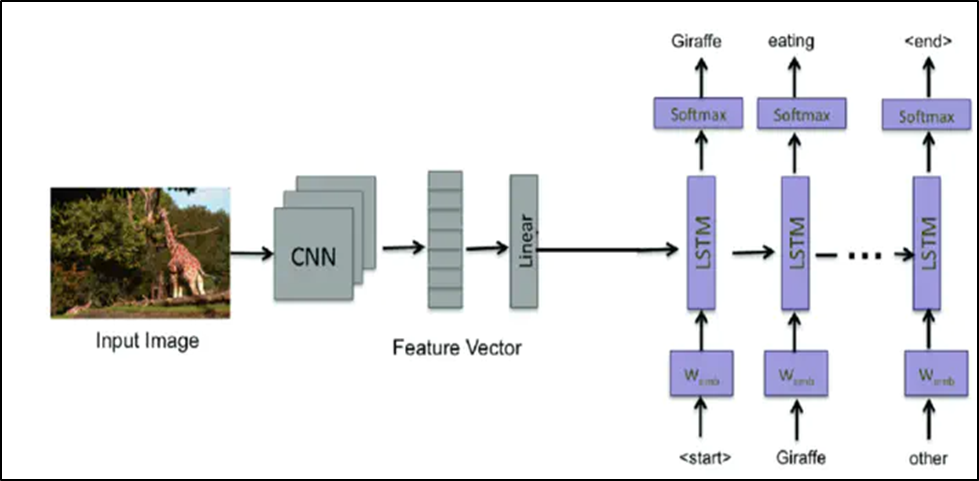

###### 11.1 Convert the cleaned captions to list

In the previous step, the captions were cleaned and saved in dictionary, in this step these captions are cleaned and saved to list. It is important because the model will not take the image_id, it will only take the captions.

In [82]:
def to_lines(descriptions):
    all_desc=list()
    for key in descriptions.keys():
        [all_desc.append(d) for d in descriptions[key]]
    return all_desc

###### 11.2 Fit a tokenizer given caption descriptions

After taking the captions, each caption should be converted to token; to enable the model to understand these captions, the bellow code is working as following:
Ahmad love icecream:
#### After token:
7 5 4 #It gives each word unique number


In [120]:
def create_tokenizer(descriptions):
    lines=to_lines(descriptions)
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [117]:
# create a list of all captions
captions_list = []
for key, value in captions.items():
    for cap in value:
        captions_list.append(cap)

# tokenize captions
tokenizer.fit_on_texts(captions_list)


In [113]:
if tokenizer.word_index:
    print("Tokenizer created successfully.")
else:
    print("Tokenizer not created.")


Tokenizer created successfully.


In [115]:
#Save the extracted features in the required directory:
# Specify the directory where the features will be saved in:
token_directory = 'C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\workingfile'

# Use os.path.join to combine the directory and the filename
filename = os.path.join(token_directory, 'tokenizer.pkl')

# save tokenizer to a file
with open('tokenizer.pkl', 'wb') as f:
    pickle.dump(tokenizer, f)

###### 11.3 Get the size of the vocabulary

The model need to know the size of the tokenizer output. (Plus one was added because it starts from zero)

In [153]:
tokenizer=create_tokenizer(train_descriptions)
vocab_size=len(tokenizer.word_index)+1
print('vocabulary Size: %d' % vocab_size)

vocabulary Size: 9090


###### 11.4 Calculate the length of the descriptions with the most frequent words

The max length will loop over the captions list in order to tell the model not to predict captions with length more than the captions that are provided in the data.

In [86]:
def max_length(descriptions):
    lines=to_lines(descriptions)
    return max(len(d.split()) for d in lines) 

In [137]:
max_length=max_length(captions) #In this case the maximum caption's length is 24.

In [138]:
max_length

24

###### 11.5  Create sequace of images, input sequances and outputwords for image

Each caption is converted to tokenizer, and then to sequence in array, then the model was trained by providing only word by word instead of full sentence, please check the document for further understanding.

In [161]:
def create_sequence(tokenizer,max_length,desc_list,photo):
    X1,X2,y=list(),list(),list()
    #Loop over the descriptions:
    for desc in desc_list:
        #Encode the sequence:
        seq=tokenizer.texts_to_sequences([desc])[0]
        #Split the sequence into multiple X,y pairs
        for i in range(1,len(seq)):
            #split into input and output pair:
            in_seq,out_seq=seq[:i],seq[i]
            #pad input sequence:
            in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
            #encode the output sequence:
            out_seq=to_categorical([out_seq],num_classes=vocab_size)[0]
            #Store the variables:
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1),array(X2),array(y)

This function takes in a tokenizer, maximum sequence length, a list of descriptions, and a photo as input. It returns three arrays: X1, X2, and y. The function processes the descriptions by encoding them into sequences using the tokenizer, splitting the sequences into input-output pairs, padding the input sequences to the specified maximum length, and encoding the output sequences using one-hot encoding. The resulting input-output pairs are then stored in the X1, X2, and y arrays respectively, with X1 containing the photo input, X2 containing the padded input sequence, and y containing the one-hot encoded output sequence.

###### 11.6 Build the deep learing RNN-LSTM model:

The model will finally produce the captions based on the training on the above lines and based on the images features and their captions. (The model was discussed in depth in the document please refer to it for further information.)

In [164]:
def define_model(vocab_size, max_length):
# Feature Extractor
    inputs1 = Input(shape=(1280,))
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(256, activation='relu')(fe1)
    # Sequence Model
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(256)(se2)

    # Decoder model
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(256, activation='relu')(decoder1)

    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Combine [image, seq] [word]
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [165]:
define_model(vocab_size, max_length)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_33 (InputLayer)          [(None, 24)]         0           []                               
                                                                                                  
 input_32 (InputLayer)          [(None, 1280)]       0           []                               
                                                                                                  
 embedding_12 (Embedding)       (None, 24, 256)      2327040     ['input_33[0][0]']               
                                                                                                  
 dropout_28 (Dropout)           (None, 1280)         0           ['input_32[0][0]']               
                                                                                           

This function defines a neural network model for image captioning. It takes in two parameters, the vocabulary size and the maximum length of the input sequences.
The model has two input layers, one for the image feature (inputs1) and one for the input sequence (inputs2).
The image feature extractor takes the image feature (1280-dimensional) as input, applies a dropout layer to prevent over fitting, and a dense layer with 256 neurons and a ReLU activation function.
The sequence model takes the input sequence, applies an embedding layer to map the integers to a dense vector representation with 256 dimensions, a dropout layer, and a LSTM layer with 256 units.
The decoder combines the feature extractor and sequence model by concatenating the output of the two layers and applies a dense layer with 256 neurons and a ReLU activation function. The final output layer has as many neurons as the vocabulary size and a softmax activation function.


###### 11.7 Data generator (call the model)

This model for training part.

In [166]:
def data_generator(descrioptions,photos,tokenizer,max_length):
    #Loop over the images:
    while 1:
        for key,desc_list in train_descriptions.items():
            photo=photos[key][0]
            in_img,in_seq,out_word=create_sequence(tokenizer,max_length,desc_list,photo)
            yield [[in_img,in_seq],out_word]

In [167]:
vocab_size = len(tokenizer.word_index) + 1
max_length = max_length
model = define_model(vocab_size, max_length)
epochs=15
j=21
steps=len(train_descriptions)
for i in range(epochs):
    #Create data generator:
    generator=data_generator(train_descriptions,train_features,tokenizer,max_length)
    history=model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)

    #Save_model:
    j=j+1
    model.save('model_DropOut0.5_'+str(j)+'.h5')

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_35 (InputLayer)          [(None, 24)]         0           []                               
                                                                                                  
 input_34 (InputLayer)          [(None, 1280)]       0           []                               
                                                                                                  
 embedding_13 (Embedding)       (None, 24, 256)      2327040     ['input_35[0][0]']               
                                                                                                  
 dropout_30 (Dropout)           (None, 1280)         0           ['input_34[0][0]']               
                                                                                           

C:\Users\hp\AppData\Local\Temp\ipykernel_9684\2386793016.py:10: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history=model.fit_generator(generator,epochs=1,steps_per_epoch=steps,verbose=1)


6000/6000 [==============================] - 842s 140ms/step - loss: 2.7873 - accuracy: 0.3613


In [ ]:
#Instead of saving each model seperately, the model can be saved as following:
# specify filepath and checkpoint settings
filepath = "model.h5"
checkpoint = ModelCheckpoint(filepath, save_best_only=False, save_weights_only=False, monitor='val_loss', mode='min', verbose=1)
callbacks_list = [checkpoint]

generator=data_generator(train_descriptions,train_features,tokenizer,24)
history = model.fit_generator(generator, epochs=epochs, callbacks=callbacks_list, steps_per_epoch=steps, verbose=1)

Other option is choose to save the model based on the best validation accuracy instead of the best validation loss by changing the monitor parameter to val_acc and the mode parameter to max in the ModelCheckpoint callback.

In [ ]:
checkpoint = ModelCheckpoint(filepath, save_best_only=False, save_weights_only=False, monitor='val_acc', mode='max', verbose=1)

###### 11.8 Data generator for implementation

## Step 12: Model testing

In [181]:
def word_for_id(integer,tokenizer):
    for word , index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [182]:
def generate_desc(model,tokenizer,photo,max_length):
    in_text='startseq'
    for i in range(max_length):
        sequence=tokenizer.texts_to_sequences([in_text])[0]
        sequence=pad_sequences([sequence],maxlen=max_length)
        yhat=model.predict([photo,sequence],verbose=0)
        yhat=argmax(yhat)
        word=word_for_id(yhat,tokenizer)
        if word is None:
            break
        in_text+=' '+word
        if word == 'endseq':
            break
    return in_text


###### Now extract the features from the new images:

In [109]:
def extract_features(filename):    
    model = MobileNetV2()

    # Remove the second-to-last layer where the claassification occur:
    model.layers.pop()

    # Create a new model using the modified MobileNetV2 model
    #The Model will take the input of the input and the output of the MobileNetV2():
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

    #The above lines will buils/call the pre-trained model. 
    #The load image step aims to load the images from the specified file and then resize it based on the model requirement.
    #The target size is basically depends on the selected model, in case of MobileNet-V2 the target size is 224*224
    image = load_img(filename, target_size=(224,224))
    #The images then is converted to array instead of tensor:
    image = img_to_array(image)
    #It is important to pass the images size based on the requirements of the model.
        
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    #function is used to normalize the input image data before it is passed through a deep learning model.
    #subtracts the mean image pixel value from each pixel and divides the result by the standard deviation of the image pixel values.
    image = preprocess_input(image)
    #The images then is provided the predict in order to predict the features. 
    feature = model.predict(image, verbose=1)
    return feature


In [178]:
tokenfile='C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\workingfile\\tokenizer.pkl'

In [184]:
from numpy import argmax
#Load the tokenizer:
tokenizer=load(open(tokenfile,'rb'))
#define the maximum length:
max_length=24
#Load the model:
model=load_model('model_DropOut0.5_22.h5')
# Load and prepare photo:
photo=extract_features('C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\Dataset\\Flicker8k_Dataset\\3482062809_3b694322c4.jpg')
#Generate descriptions:
description=generate_desc(model,tokenizer,photo,max_length)
print(description)

1/1 [==============================] - 5s 5s/step
startseq رجل في قميص أحمر في الهواء endseq


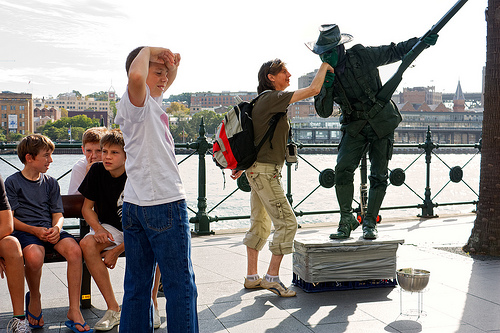

In [172]:
from IPython.display import Image
Image(filename='C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\Dataset\\Flicker8k_Dataset\\3482062809_3b694322c4.jpg')

1/1 [==============================] - 2s 2s/step
startseq رجل يرتدي قبعة بيضاء يقف بجانب نافذة endseq


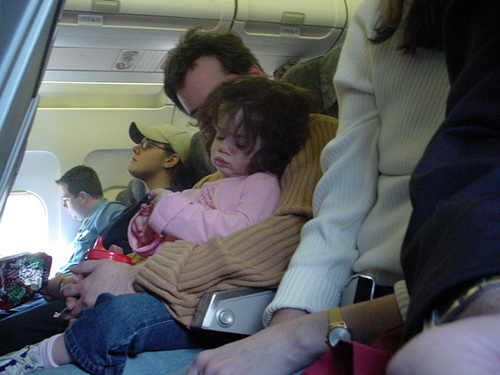

In [206]:
#Load the tokenizer:
tokenizer=load(open(tokenfile,'rb'))
#define the maximum length:
max_length=24
#Load the model:
model=load_model('model_DropOut0.5_33.h5')
# Load and prepare photo:
photo=extract_features('C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\Dataset\\Flicker8k_Dataset\\2921094201_2ed70a7963.jpg')
#Generate descriptions:
description=generate_desc(model,tokenizer,photo,max_length)
print(description)
Image(filename='C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\Dataset\\Flicker8k_Dataset\\2921094201_2ed70a7963.jpg')

1/1 [==============================] - 1s 1s/step
startseq رجل يرتدي سترة حمراء يركب دراجة endseq


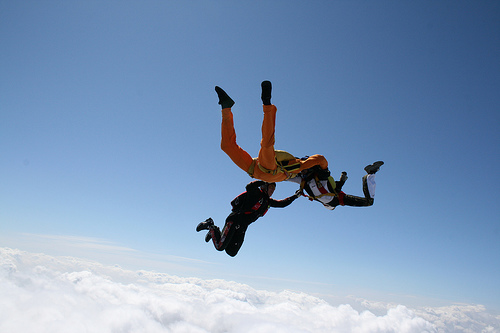

In [204]:
#Load the tokenizer:
tokenizer=load(open(tokenfile,'rb'))
#define the maximum length:
max_length=24
#Load the model:
model=load_model('model_DropOut0.5_23.h5')
# Load and prepare photo:
photo=extract_features('C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\Dataset\\Flicker8k_Dataset\\3339140382_2e49bc324a.jpg')
#Generate descriptions:
description=generate_desc(model,tokenizer,photo,max_length)
print(description)
Image(filename='C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\Dataset\\Flicker8k_Dataset\\3339140382_2e49bc324a.jpg')

1/1 [==============================] - 2s 2s/step
startseq رجل يرتدي خوذة زرقاء يتسلق صخرة endseq


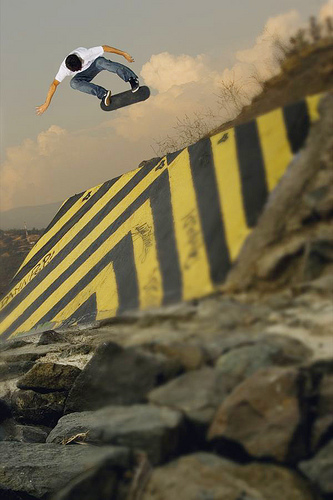

In [197]:
#Load the tokenizer:
tokenizer=load(open(tokenfile,'rb'))
#define the maximum length:
max_length=24
#Load the model:
model=load_model('model_DropOut0.5_36.h5')
# Load and prepare photo:
photo=extract_features('C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\Dataset\\Flicker8k_Dataset\\3221036999_3f7b152d8a.jpg')
#Generate descriptions:
description=generate_desc(model,tokenizer,photo,max_length)
print(description)
Image(filename='C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\Dataset\\Flicker8k_Dataset\\3221036999_3f7b152d8a.jpg')

1/1 [==============================] - 3s 3s/step
startseq فتاة صغيرة تقفز في بركة endseq


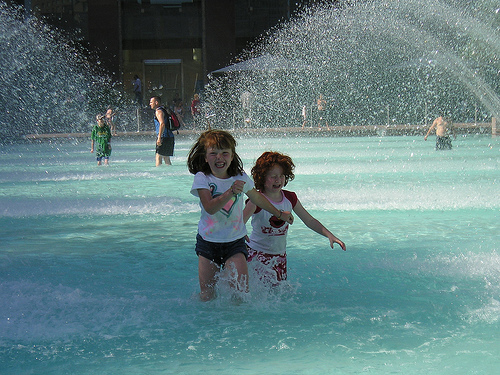

In [194]:
#Load the tokenizer:
tokenizer=load(open(tokenfile,'rb'))
#define the maximum length:
max_length=24
#Load the model:
model=load_model('model_DropOut0.5_35.h5')
# Load and prepare photo:
photo=extract_features('C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\Dataset\\Flicker8k_Dataset\\2453971388_76616b6a82.jpg')
#Generate descriptions:
description=generate_desc(model,tokenizer,photo,max_length)
print(description)
Image(filename='C:\\Users\\hp\\Desktop\\Personal files\\HTU\\python\\project\\Dataset\\Flicker8k_Dataset\\2453971388_76616b6a82.jpg')